# Phenotypic uncertainty explained by the sensitivity of a genome to changes in transcription:

---

## loading required libraries:

In [1]:
library("jtools")
library("tidyverse")

Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.6
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## loading working database from file:

In [2]:
working.db <- read_csv("File_S1.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  org_id = col_double(),
  phen_id = col_double(),
  trans_id = col_double(),
  n_env = col_double(),
  trans_length = col_double(),
  fitness = col_double(),
  equ = col_double(),
  xor = col_double(),
  nor = col_double(),
  andn = col_double(),
  or = col_double(),
  orn = col_double(),
  and = col_double(),
  nand = col_double(),
  not = col_double()
)




## getting data:

In [8]:
#single-phenotype => plastic_phen = 0
#plastic-phenotype => plastic_phen = 1
#robust-transcriptome = sensitive_trans = 0
#sensitive-transcriptome = sensitive_trans = 1
db1 <- working.db %>%
    group_by(org_id) %>%
    summarise(n_phen = n_distinct(phen_id), n_trans = n_distinct(trans_id), n_env = sum(n_env), .groups = 'drop') %>%
    mutate(plastic_phen = as.factor(ifelse(n_phen == 1, 0, 1)),
           sensitive_trans = as.factor(ifelse(n_trans == 1, 0, 1))) %>%
    select(org_id, plastic_phen, sensitive_trans, n_env)

db2 <- inner_join(working.db,
                 db1 %>% select(org_id, plastic_phen, sensitive_trans),
                 by = "org_id") %>%
    group_by(org_id, plastic_phen, sensitive_trans) %>%
    summarize(p_not = sum(not)/n(),
              p_nand = sum(nand)/n(),
              p_and = sum(and)/n(),
              p_orn = sum(orn)/n(),
              p_or = sum(or)/n(),
              p_andn = sum(andn)/n(),
              p_nor = sum(nor)/n(),
              p_xor = sum(xor)/n() ,
              p_equ = sum(equ)/n(),
              .groups = 'drop') %>%
    filter(plastic_phen == 1) %>%
    select(-plastic_phen)

db <- db2 %>% pivot_longer(!org_id & !sensitive_trans, names_to = "trait", values_to = "p") %>%
    # select only those boolean functions that contribute to phenotypic plasticity
    filter(p != 0 & p != 1) %>%
    mutate(shannon = -(p*log2(p) + (1-p)*log2(1-p)))

## showing some data:

In [15]:
db %>% head
db %>% tail

org_id sensitive_trans trait  p        shannon  
1  365   0               p_orn  0.500000 1.0000000
2 1003   0               p_not  0.500000 1.0000000
3 1007   0               p_orn  0.500000 1.0000000
4 1009   1               p_not  0.437500 0.9886994
5 1009   1               p_nand 0.015625 0.1161151
6 1009   1               p_orn  0.015625 0.1161151

org_id sensitive_trans trait  p         shannon  
1 511992 1               p_andn 0.4285714 0.9852281
2 511992 1               p_nor  0.4285714 0.9852281
3 511992 1               p_xor  0.4285714 0.9852281
4 511992 1               p_equ  0.4285714 0.9852281
5 511996 0               p_nand 0.5000000 1.0000000
6 511996 0               p_xor  0.5000000 1.0000000

## generalized linear regression model (Table 1, right):

In [14]:
m <- glm(shannon ~ sensitive_trans,
         data = db,
         family = quasibinomial(link = "logit"))
summary(m)
summ(m, robust = "HC1", scale = FALSE, confint = TRUE, digits = 3, pvals = FALSE, exp = FALSE)


Call:
glm(formula = shannon ~ sensitive_trans, family = quasibinomial(link = "logit"), 
    data = db)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8675  -0.2437   0.2066   0.4369   0.8367  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.301153   0.002496     922   <2e-16 ***
sensitive_trans1 -1.431434   0.003231    -443   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasibinomial family taken to be 0.2625186)

    Null deviance: 270346  on 808980  degrees of freedom
Residual deviance: 215561  on 808979  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Note: Pseudo-R2 for quasibinomial/quasipoisson families is calculated by
refitting the fitted and null models as binomial/poisson.

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


MODEL INFO:
Observations: 808981
Dependent Variable: shannon
Type: Generalized linear model
  Family: quasibinomial 
  Link function: logit 

MODEL FIT:
χ²(1) = 54784.898, p = 0.000
Pseudo-R² (Cragg-Uhler) = 0.217
Pseudo-R² (McFadden) = 0.166
AIC =   NA, BIC =   NA 

Standard errors: Robust, type = HC1
------------------------------------------------------------
                           Est.     2.5%    97.5%     t val.
---------------------- -------- -------- -------- ----------
(Intercept)               2.301    2.297    2.305   1131.696
sensitive_trans1         -1.431   -1.438   -1.425   -436.540
------------------------------------------------------------

Estimated dispersion parameter = 0.263 

## plotting:

Warning message:
“sensitive_trans and sensitive_trans are not included in an interaction with
one another in the model.”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



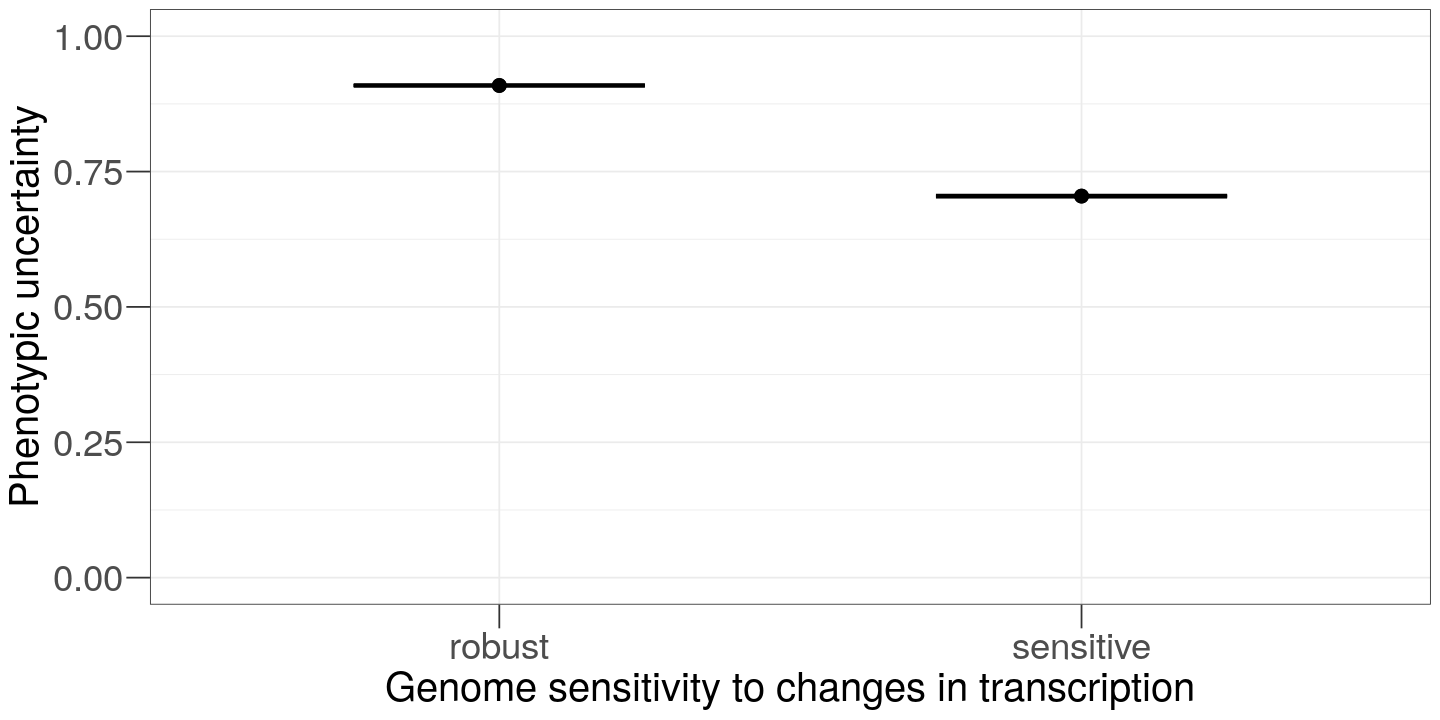

In [16]:
options(repr.plot.width = 12, repr.plot.height = 6)
cat_plot(m, pred = sensitive_trans, modx = sensitive_trans, geom = "line", vary.lty = FALSE,
         x.label = "Genome sensitivity to changes in transcription",
         y.label = "Phenotypic uncertainty",
         line.thickness = 1.0,
         colors = c("black", "black")) +
ylim(c(0, 1)) +
scale_x_discrete(label = c("0" = "robust", "1" = "sensitive")) +
theme_bw() +
theme(axis.title = element_text(size = 24),
      axis.text = element_text(size = 22),
      axis.ticks.length = unit(0.5, "cm"),
      legend.position = "none")

---